# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [81]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [82]:
#Create a connection with create_engine to MySQL Workbench:
# SQL CONNECTION

import mysql.connector
import getpass

saved_password = getpass.getpass()

# open the door between python and my databases ->  I specified Sakila
cnx = mysql.connector.connect(user='root', password=saved_password, database='sakila', port=3306)

# check if the connection was successful
cnx.is_connected()

# we need to define the object we will use to interact with the database
cursor = cnx.cursor(buffered=True)

query = ("SELECT * FROM lab_unsupervised_learning.wholesale_customers_data;")
cursor.execute(query)

# Fetch column names from cursor description
column_names = [col[0] for col in cursor.description]

# Fetch all results
results = cursor.fetchall()

# Create a DataFrame with fetched data and column names
wholesale_customers_data = pd.DataFrame(results, columns=column_names)

# Close cursor and database connection
cursor.close()
cnx.close()

In [83]:
wholesale_customers_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

According to the source of the dataset, there is no ordinal data. 

In [84]:
# Your code here:
wholesale_customers_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


There is no missing data

In [85]:
# Channel and Region are categorical according to source and they need to be encoded: 
wholesale_customers_data = pd.get_dummies(wholesale_customers_data, columns=['Channel', 'Region'])

In [86]:
wholesale_customers_data.columns

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen',
       'Channel_1', 'Channel_2', 'Region_1', 'Region_2', 'Region_3'],
      dtype='object')

In [87]:
numerical = wholesale_customers_data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]

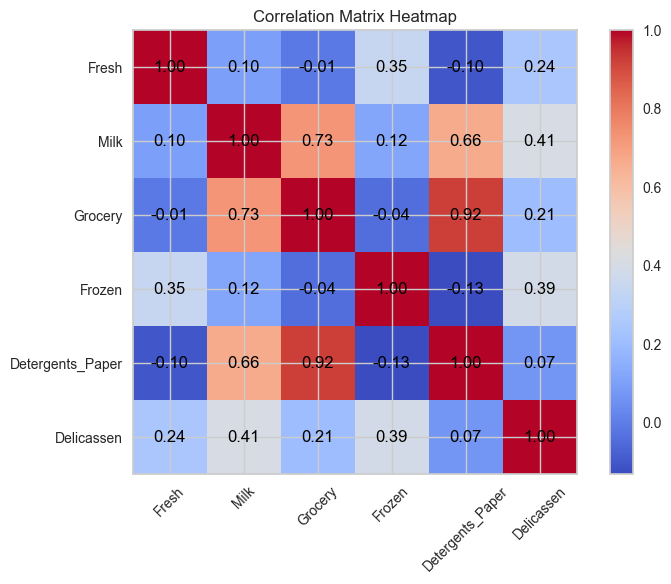

In [88]:
correlation_matrix = numerical.corr()

plt.figure(figsize=(8, 6))
plt.title('Correlation Matrix Heatmap')
heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Add annotation
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='black')

plt.colorbar(heatmap)
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.index)), correlation_matrix.index)
plt.tight_layout()
plt.show()

Variables 'Detergents_Paper' and 'Grocery' have a very high correlation. We could remove 'Grocery' because it has a slightly higher correlation to 
the other features than ''Detergents_Paper'

In [89]:
numerical.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


The data is in different ranges, we`re going to have to scale it. 

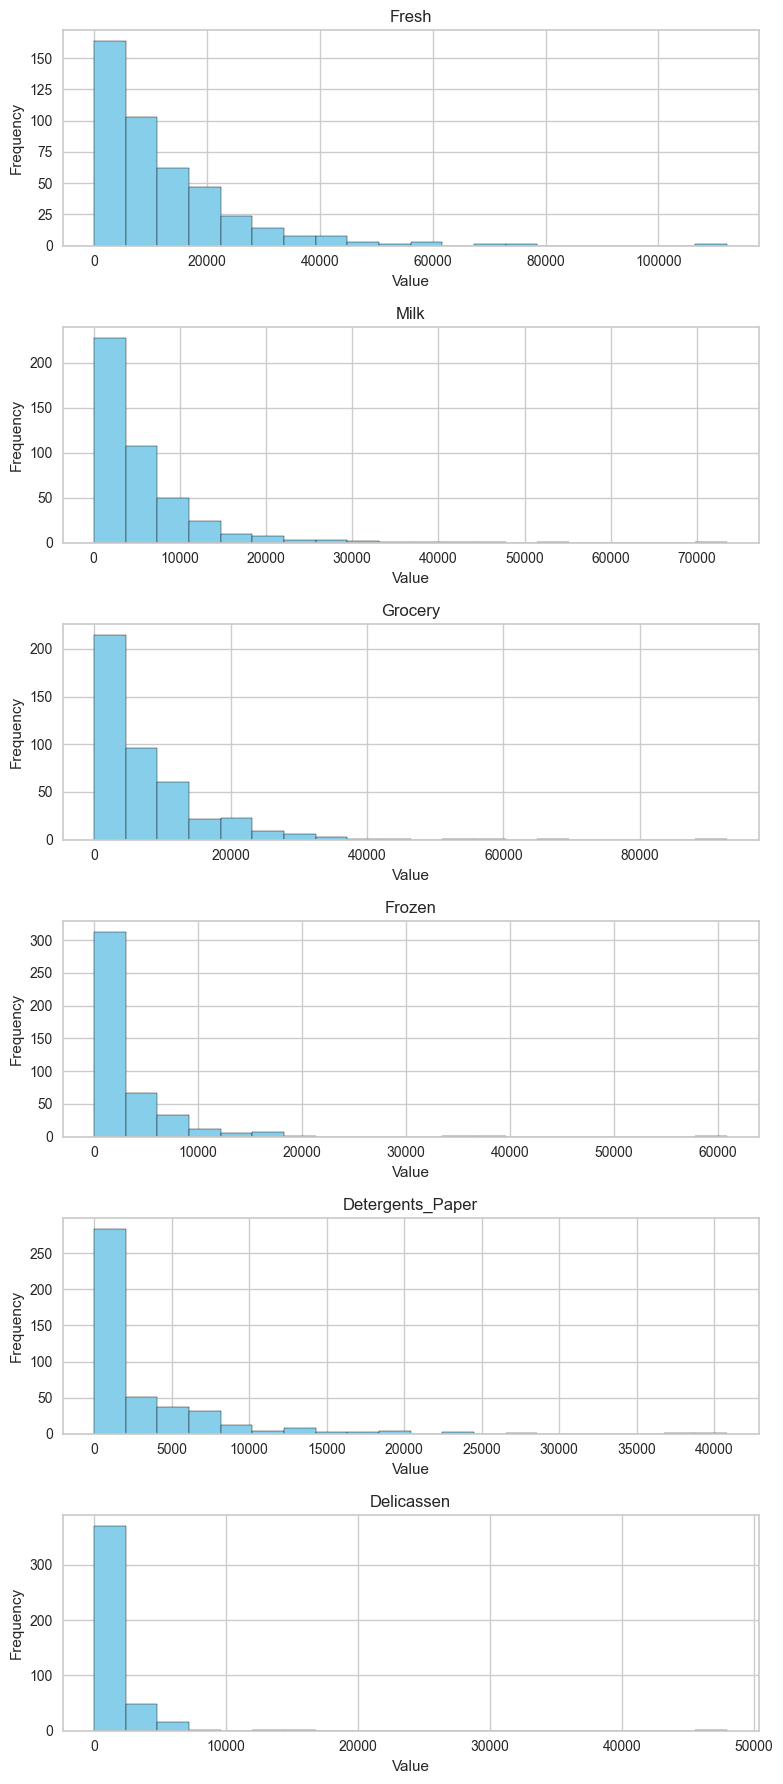

In [90]:
column_names = numerical.columns

# Set up the figure and axes
num_cols = len(column_names)
fig, axs = plt.subplots(num_cols, 1, figsize=(8, 3*num_cols))  # Adjusted figsize here

# Plot histograms for each column
for i, col in enumerate(column_names):
    axs[i].hist(numerical[col], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(col)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

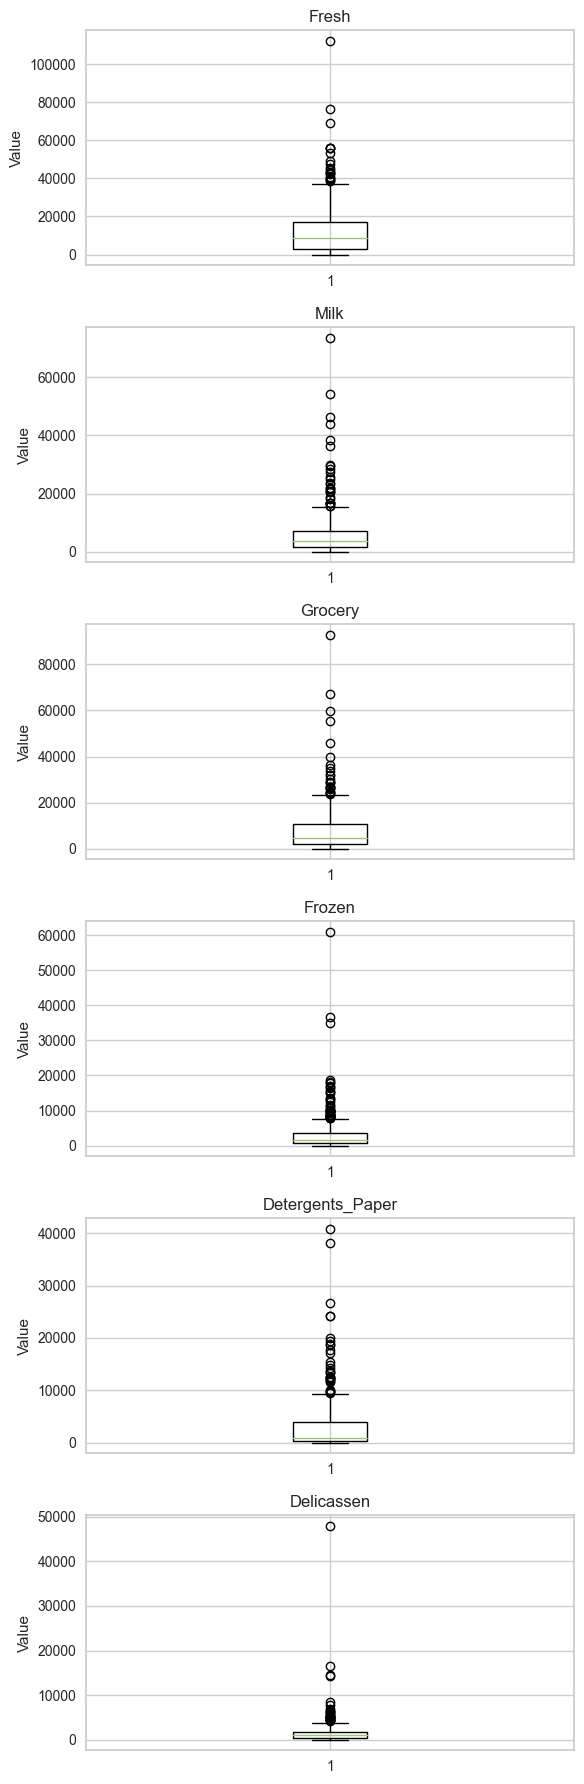

In [91]:
num_cols = len(numerical.columns)
fig, axs = plt.subplots(num_cols, 1, figsize=(6, 3*num_cols))

# Plot boxplots for each column
for i, col in enumerate(numerical.columns):
    axs[i].boxplot(numerical[col])
    axs[i].set_title(col)
    axs[i].set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.show()

All the numerical columns are right skewed, there are significat outliers. 
For KMeans we will remove them, for DBSCAN it is not necessary.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [92]:
# Your code here
# removing grocery because of high correlation: 
wholesale_customers_data.drop(columns=['Grocery'], inplace=True)

Removing outliers according to what we saw in the boxplots and histograms: 

In [93]:
wholesale_cd_no_out = wholesale_customers_data[wholesale_customers_data['Fresh'] <= 100000]
wholesale_cd_no_out = wholesale_customers_data[wholesale_customers_data['Milk'] <= 60000]
wholesale_cd_no_out = wholesale_customers_data[wholesale_customers_data['Frozen'] <= 50000]
wholesale_cd_no_out = wholesale_customers_data[wholesale_customers_data['Detergents_Paper'] <= 30000]
wholesale_cd_no_out = wholesale_customers_data[wholesale_customers_data['Delicassen'] <= 50000]


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [94]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
scaler.fit(wholesale_cd_no_out)
X_scaled_np = scaler.fit_transform(wholesale_cd_no_out)
X_scaled_df = pd.DataFrame(X_scaled_np, columns=wholesale_cd_no_out.columns)


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [95]:
# Your code here:
from sklearn.cluster import KMeans
from sklearn import metrics
import plotly.express as px
from sklearn import cluster
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.cluster import SilhouetteVisualizer

The following code was copied from https://builtin.com/data-science/elbow-method

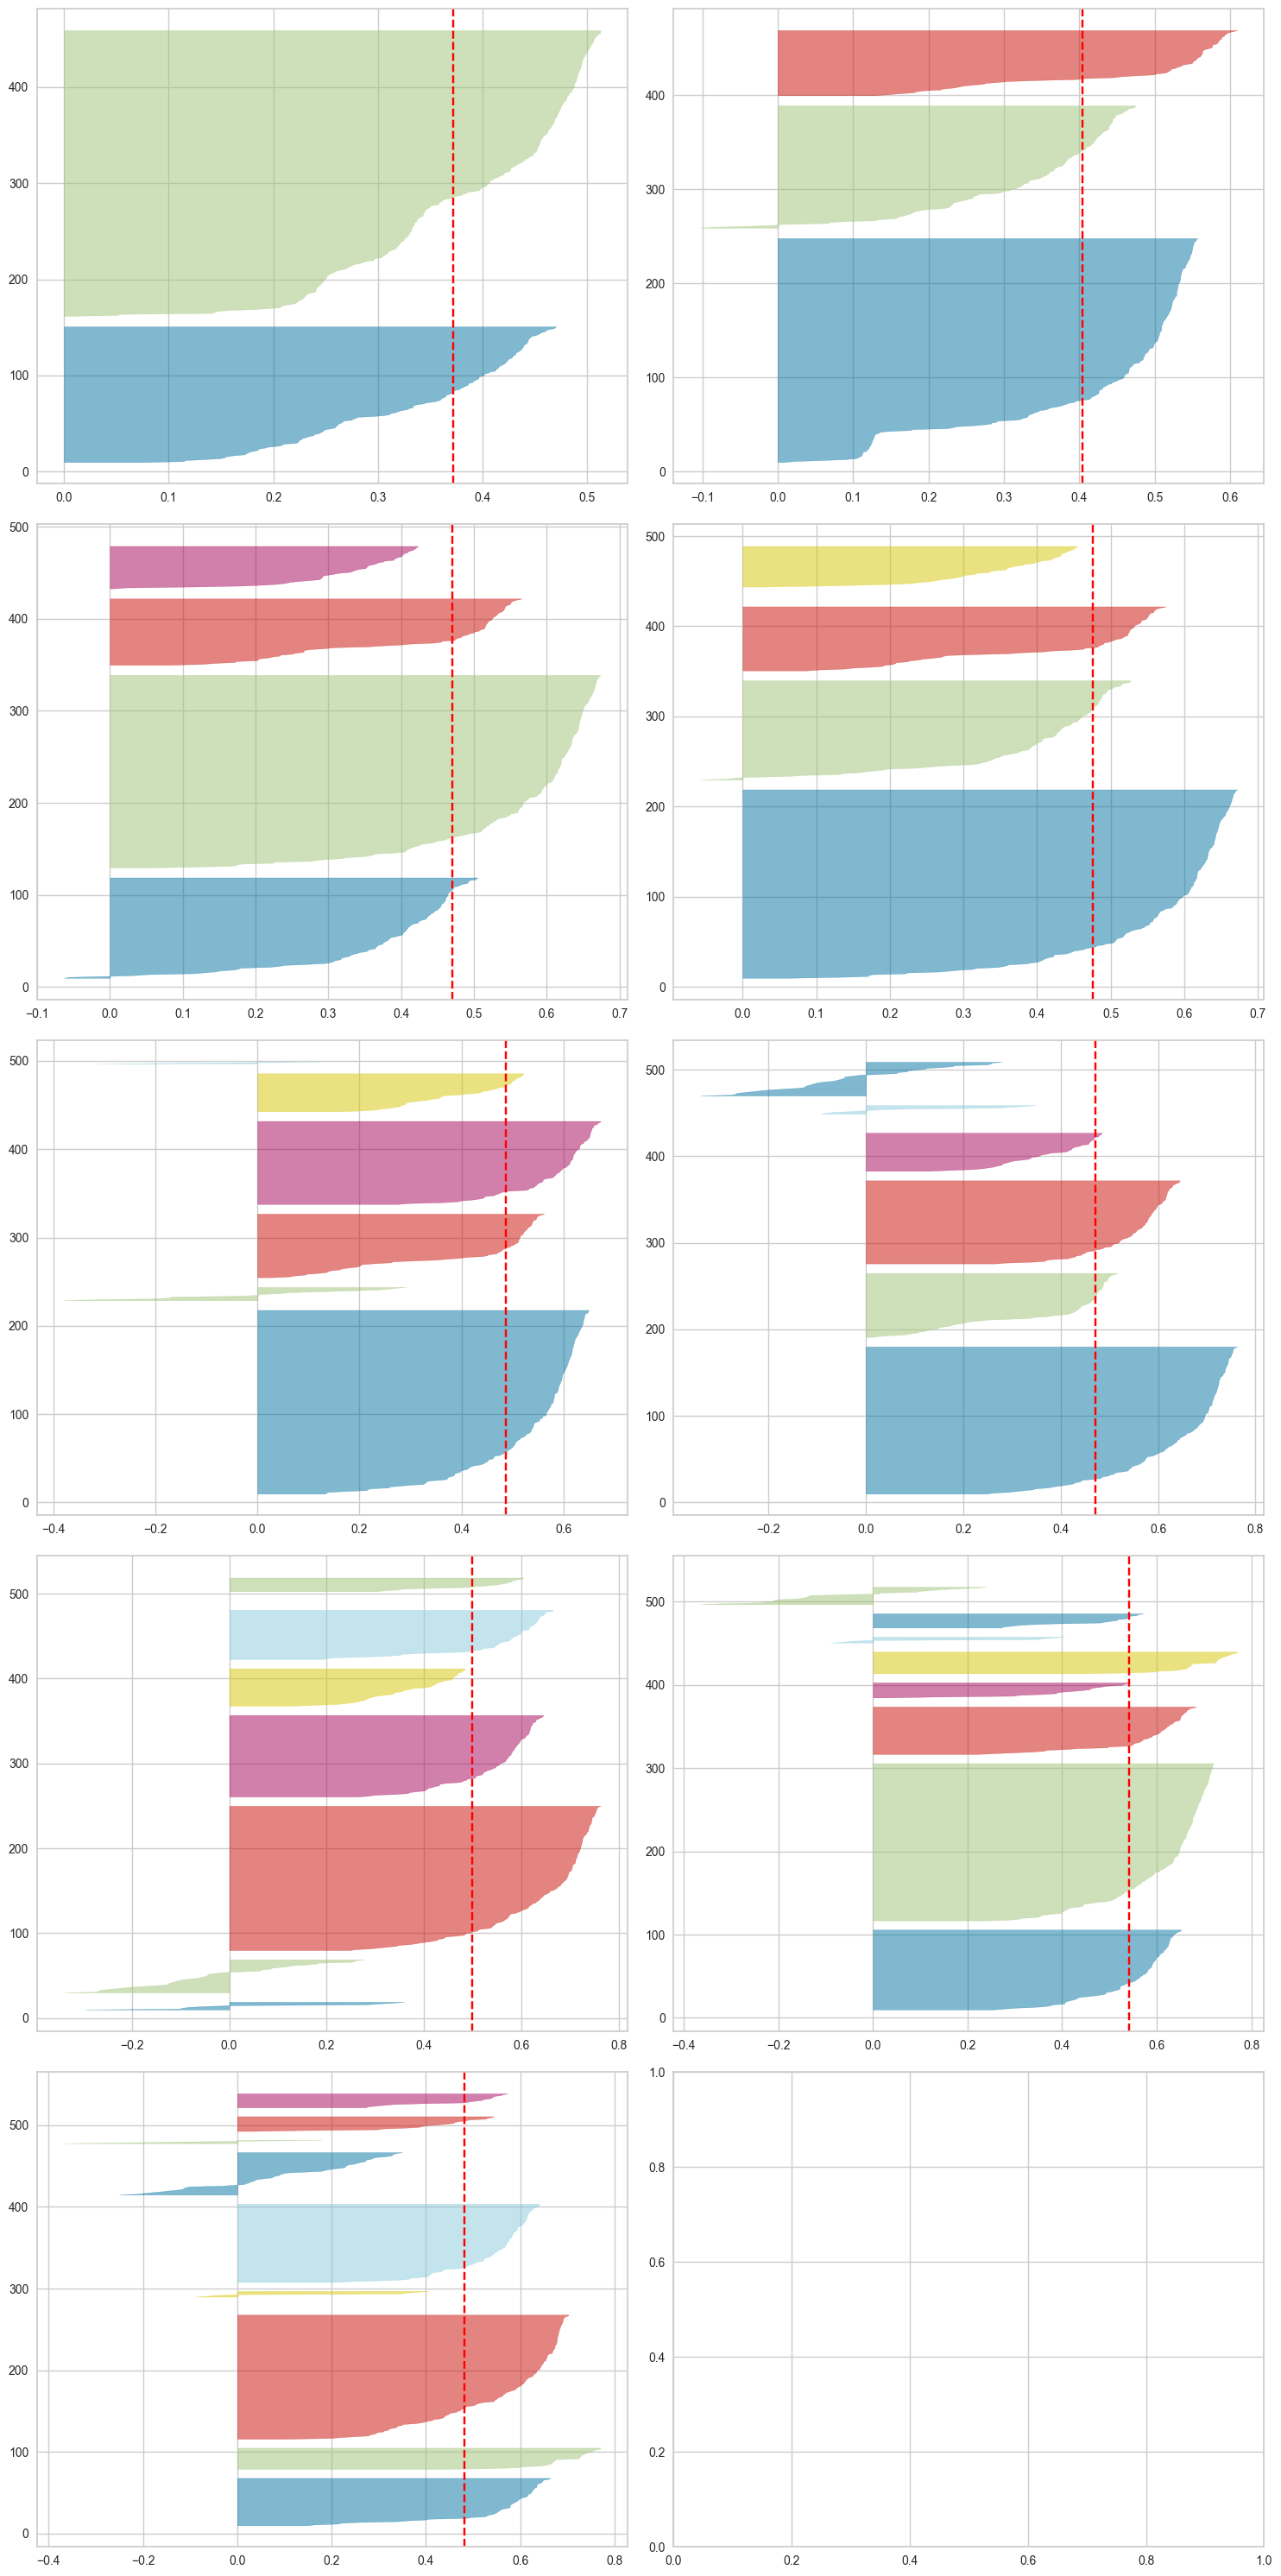

In [96]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))  # 5 rows and 2 columns for subplots
for i in range(2, 11):
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i - 2, 2)  

    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(X_scaled_df)

plt.tight_layout()
plt.show()

Looks like k=5 is the best from the above, even though one cluster is very tiny and it`s silhoutte score is slightly under the average of the model. 

Count the values in `labels`.

In [97]:
# Your code here:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled_df)

cluster_labels = kmeans.predict(X_scaled_df)

wholesale_cd_no_out['KMeans_labels'] = cluster_labels

In [98]:
wholesale_cd_no_out['KMeans_labels'].value_counts()

0    208
1    111
3     72
4     45
2      4
Name: KMeans_labels, dtype: int64

Those don't look good at all...I'll try with k=3 too. 

In [99]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled_df)

cluster_labels = kmeans.predict(X_scaled_df)

wholesale_cd_no_out['KMeans_labels'] = cluster_labels

In [100]:
wholesale_cd_no_out['KMeans_labels'].value_counts()

0    211
1    140
2     89
Name: KMeans_labels, dtype: int64

That looks somewhat better. 

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [101]:
# Your code here
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean
from sklearn.metrics import calinski_harabasz_score


Count the values in `labels_DBSCAN`.

In [102]:
# Your code here
# Creating the clustering model
model = DBSCAN() # Default values are: eps=0.5, min_samples=5
# fit model and predict clusters
yhat = model.fit_predict(X_scaled_df)


In [103]:
clusters = np.unique(yhat)
clusters

array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64)

cluster -1 are the outliers 

In [104]:
[cluster for cluster in list(clusters) if cluster != -1]

[0, 1, 2, 3, 4, 5, 6, 7]

In [105]:
wholesale_cd_no_out['DBSCAN_labels'] = yhat
wholesale_cd_no_out['DBSCAN_labels'].value_counts()

-1    203
 2    144
 0     35
 5     23
 7     14
 1      7
 6      6
 3      5
 4      3
Name: DBSCAN_labels, dtype: int64

Clusters vary very much in size and the '-1' has way too many values. 

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

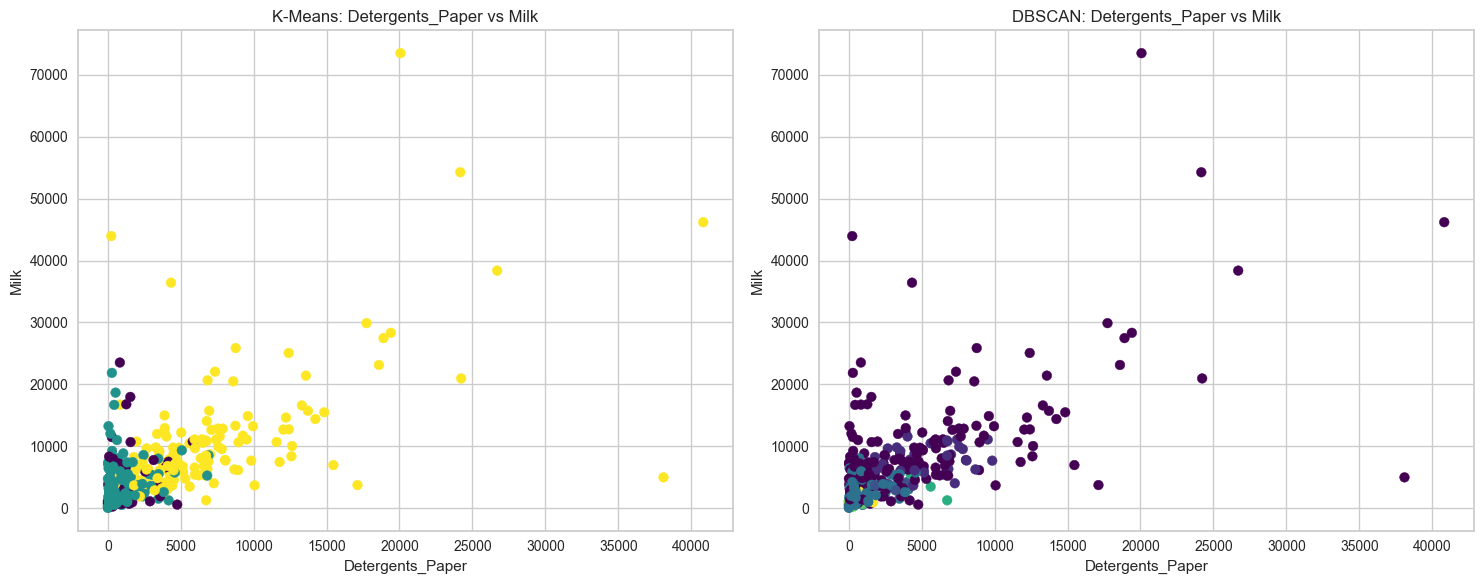

In [80]:
# Your code here:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot scatter plot for K-Means clustering
axs[0].scatter(wholesale_cd_no_out['Detergents_Paper'], wholesale_cd_no_out['Milk'], c=wholesale_cd_no_out['KMeans_labels'], cmap='viridis')
axs[0].set_title('K-Means: Detergents_Paper vs Milk')
axs[0].set_xlabel('Detergents_Paper')
axs[0].set_ylabel('Milk')

# Plot scatter plot for DBSCAN clustering
axs[1].scatter(wholesale_cd_no_out['Detergents_Paper'], wholesale_cd_no_out['Milk'], c=wholesale_cd_no_out['DBSCAN_labels'], cmap='viridis')
axs[1].set_title('DBSCAN: Detergents_Paper vs Milk')
axs[1].set_xlabel('Detergents_Paper')
axs[1].set_ylabel('Milk')

# Adjust layout
plt.tight_layout()
plt.show()



Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

KeyError: 'Grocery'

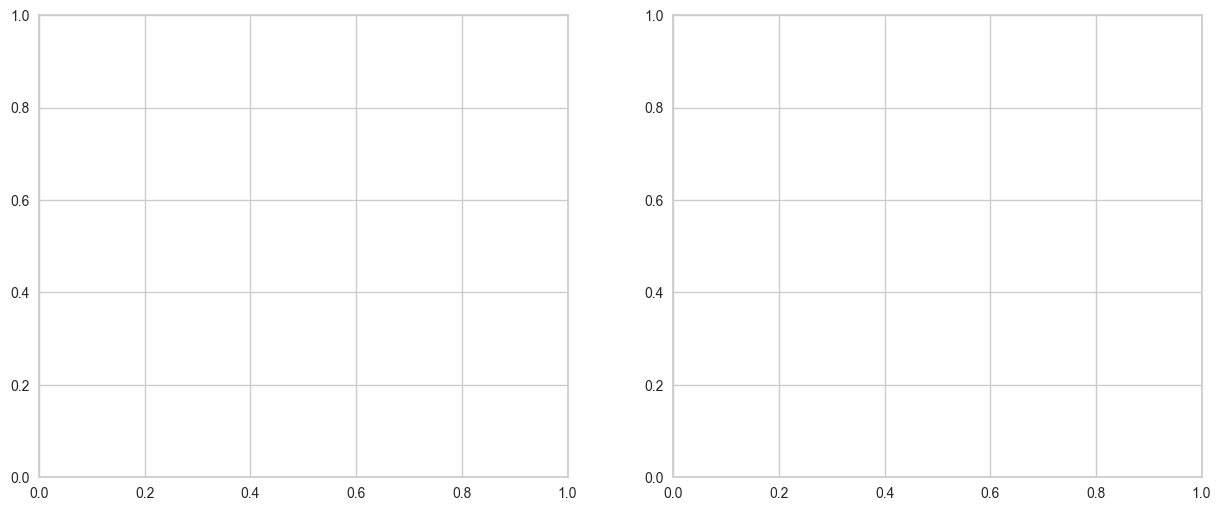

In [106]:
# Your code here:

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot scatter plot for K-Means clustering
axs[0].scatter(wholesale_cd_no_out['Grocery'], wholesale_cd_no_out['Fresh'], c=wholesale_cd_no_out['KMeans_labels'], cmap='viridis')
axs[0].set_title('K-Means: Grocery vs Fresh')
axs[0].set_xlabel('Grocery')
axs[0].set_ylabel('Fresh')

# Plot scatter plot for DBSCAN clustering
axs[1].scatter(wholesale_cd_no_out['Grocery'], wholesale_cd_no_out['Fresh'], c=wholesale_cd_no_out['DBSCAN_labels'], cmap='viridis')
axs[1].set_title('DBSCAN: Grocery vs Fresh')
axs[1].set_xlabel('Grocery')
axs[1].set_ylabel('Fresh')

# Adjust layout
plt.tight_layout()
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

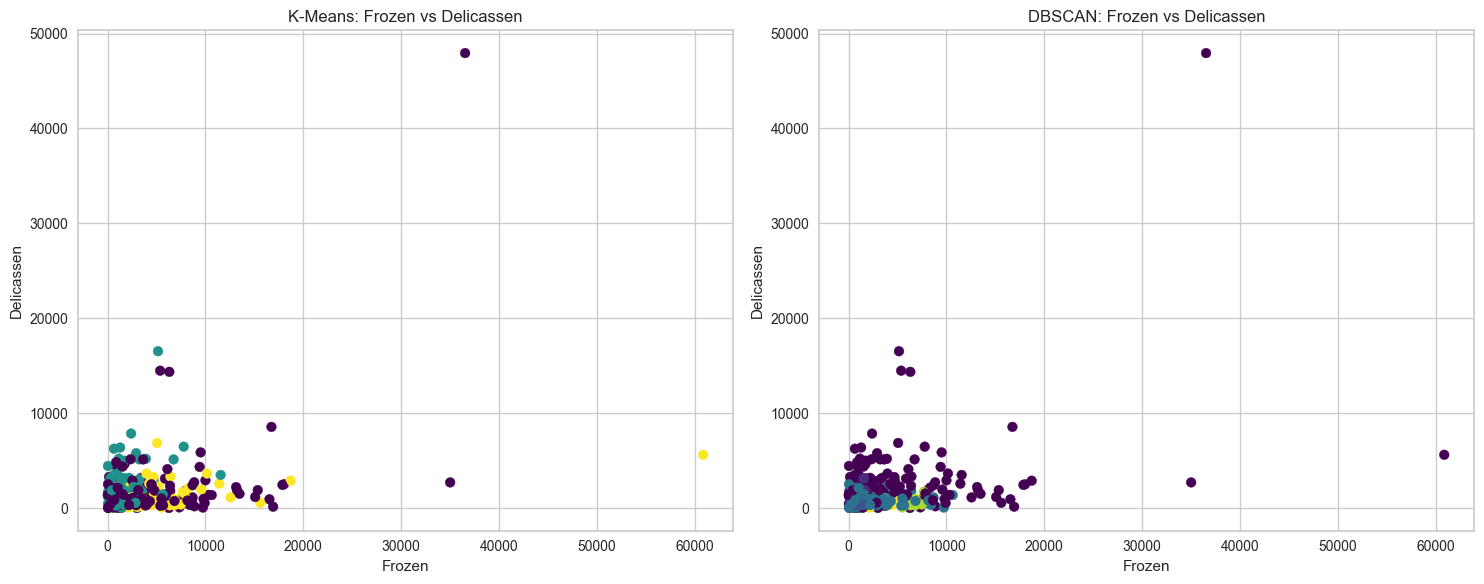

In [108]:
# Your code here:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot scatter plot for K-Means clustering
axs[0].scatter(wholesale_cd_no_out['Frozen'], wholesale_cd_no_out['Delicassen'], c=wholesale_cd_no_out['KMeans_labels'], cmap='viridis')
axs[0].set_title('K-Means: Frozen vs Delicassen')
axs[0].set_xlabel('Frozen')
axs[0].set_ylabel('Delicassen')

# Plot scatter plot for DBSCAN clustering
axs[1].scatter(wholesale_cd_no_out['Frozen'], wholesale_cd_no_out['Delicassen'], c=wholesale_cd_no_out['DBSCAN_labels'], cmap='viridis')
axs[1].set_title('DBSCAN: Frozen vs Delicassen')
axs[1].set_xlabel('Frozen')
axs[1].set_ylabel('Delicassen')

# Adjust layout
plt.tight_layout()
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [109]:
# Your code here:
kmeans_means = wholesale_cd_no_out.groupby('KMeans_labels').mean()
dbscan_means = wholesale_cd_no_out.groupby('DBSCAN_labels').mean()

print("Mean values for K-Means clustering:")
print(kmeans_means)

print("\nMean values for DBSCAN clustering:")
print(dbscan_means)

Mean values for K-Means clustering:
                      Fresh          Milk       Frozen  Detergents_Paper  \
KMeans_labels                                                              
0              13878.052133   3486.981043  3656.900474        786.682464   
1               8932.514286  10808.764286  1576.700000       7360.907143   
2              12374.269663   3386.258427  4037.146067        801.573034   

                Delicassen  Channel_1  Channel_2  Region_1  Region_2  \
KMeans_labels                                                          
0              1518.284360   1.000000   0.000000  0.000000  0.000000   
1              1753.507143   0.000000   1.000000  0.114286  0.135714   
2              1180.831461   0.977528   0.022472  0.685393  0.314607   

               Region_3  DBSCAN_labels  
KMeans_labels                           
0                  1.00       1.142180  
1                  0.75      -0.542857  
2                  0.00       2.280899  

Mean values for 

Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here